In [1]:
%reset -f
%load_ext autoreload
%autoreload 2

import networkx as nx
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn.conv import SAGEConv
from torch_geometric.utils import to_dense_adj
from torch_geometric.nn import GCNConv, global_mean_pool, global_max_pool
from torch_geometric.nn.models import GraphSAGE, GAE
from torch_geometric.data import DataLoader
from torch_geometric.utils import from_networkx, to_undirected
import networkx as nx
import random
import torch
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
import gantt_plotter_matplotlib
import graph_prediction
from schedule_to_graph_converter import schedule_data_to_igraph, schedule_data_to_nxgraph
from torch_geometric.data import DataLoader, DataListLoader
import os
import igraph as ig
from shifting_agent_gnn.environment.instances.parser import parse_instance
from copy_helper import fast_deepcopy
from scipy.spatial.distance import pdist

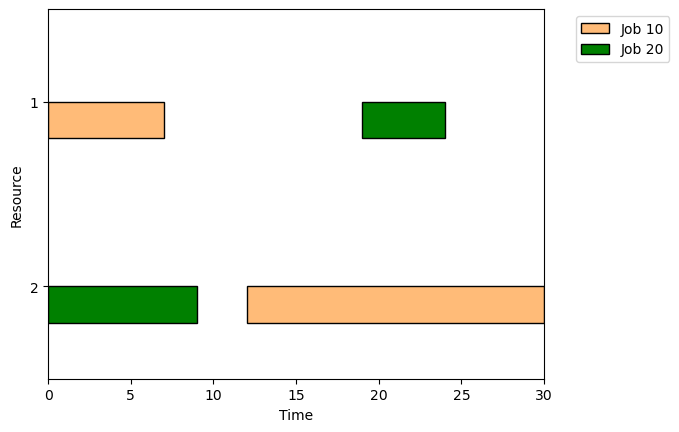

In [2]:
schedule_data = [
        {
            'start_time': 0,
            'end_time': 7,
            'resource': 1,
            'job': 10
        },
        {
            'start_time': 0,
            'end_time': 9,
            'resource': 2,
            'job': 20
        },
        {
            'start_time': 19,
            'end_time': 24,
            'resource': 1,
            'job': 20
        },
        {
            'start_time': 12,
            'end_time': 30,
            'resource': 2,
            'job': 10
        },
    ]
gantt_plotter_matplotlib.plot_gantt(schedule_data)

In [3]:
graph, edge_attr = schedule_to_graph_converter.schedule_data_to_graph(schedule_data)
schedule_to_graph_converter.plot_graph(graph)
pprint(edge_attr)

NameError: name 'schedule_to_graph_converter' is not defined

In [ ]:
instance_path = "./../shifting_agent_gnn/environment/instances/hurink_edata/"
schedules = os.listdir(instance_path)
parse_instance(instance_path + schedules[0])

In [ ]:
# random_schedule = graph_prediction.generate_random_schedule(3, 5, [3]* 5)
# schedules = os.listdir("./../shifting_agent_gnn/environment/instances/hurink_edata/")
# Trainingsdaten
X = []
for s in graph_prediction.generate_training_data(n_samples=500):
    graph, edge_attr = schedule_to_graph_converter.schedule_data_to_graph(s)
    X.append(graph)

In [ ]:
train_test_split_idx = 400
def convert_to_torch_geometric(graph: nx.DiGraph):
    # Fügen Sie hier ggf. Kanten- und Knotenattribute hinzu
    return from_networkx(graph, group_edge_attrs=['time_dist', 'edge_type'])

torch_geometric_graphs = [convert_to_torch_geometric(g) for g in X]
dataset = DataListLoader(torch_geometric_graphs[:train_test_split_idx], batch_size=1)
dataset_test = DataListLoader(torch_geometric_graphs[train_test_split_idx:], batch_size=1)

In [ ]:
input_features = 6  # Anzahl der Eingabemerkmale (Knotenattribute)
hidden_features = 64  # Anzahl der versteckten Merkmale
latent_dim = 128
output_size = 32  # Anzahl der gewünschten Ausgabemerkmale (Maximale Anzahl Knoten)
num_layers = 3  # Anzahl der Schichten in Ihrem GraphSAGE-Modell

In [8]:
class GraphAutoEncoder(nn.Module):
    """Einfaches Autoencoder Modell - Stellt nur die Adj Matrix wieder her"""
    def __init__(self, input_dim, hidden_dim, latent_dim, num_layers):
        super(GraphAutoEncoder, self).__init__()
        self.sage_net = GraphSAGE(in_channels=input_dim, hidden_channels=hidden_dim,
                                   out_channels=latent_dim, num_layers=num_layers)

    def forward(self, x, edge_index, edge_attr):
        # Encoder Output Shape: (Knoten x Latent Dim)
        encoding = self.sage_net(x, edge_index, edge_attr=edge_attr)
        # Decoder (reconstruction)
        decoding = torch.sigmoid(torch.matmul(encoding, encoding.t()))
        decoding = torch.triu(decoding, diagonal=1)
        return encoding, decoding

In [13]:
class GraphEncoderPooling(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(GraphEncoderPooling, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, latent_dim)

    def forward(self, x, edge_index, batch):
        x = torch.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        
        # Global mean pooling to obtain a fixed-size graph embedding
        x = global_mean_pool(x, batch)
        return x

class GraphAutoEncoderPooling(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(GraphAutoEncoder, self).__init__()
        self.encoder = GraphEncoderPooling(input_dim, hidden_dim, latent_dim)
        """  
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )
        """

    def forward(self, x, edge_index, batch):
        z = self.encoder(x, edge_index, batch)
        
        # Decoder (reconstruction)
        # recon_x = self.decoder(z)
        # simple inner product reconstruction
        
        return z, recon_x

In [16]:
# Optimierer festlegen
# model = GraphAutoEncoder(input_features, hidden_features, latent_dim, 5)
# model = GAE(SAGEConv(input_features, hidden_features, 3))
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
model = GAE(GCNConv(input_features, hidden_features, 3)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-4)

# Trainingsfunktion
def train():
    model.train()
    total_loss = 0
    for batch in dataset:
        optimizer.zero_grad()
        x = batch[0].info
        edge_index, batch_idx = batch[0].edge_index, batch[0].batch
        edge_attr = batch[0].edge_attr
        edge_index, edge_attr = to_undirected(edge_index, edge_attr)
        encoding = model.encode(x.float().to(device), edge_index.to(device))
        # loss = F.mse_loss(decoding, to_dense_adj(edge_index).squeeze())  # Verlustfunktion (Mean Squared Error)
        loss = model.recon_loss(encoding, edge_index)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataset)

def test():
    with torch.no_grad():
        total_loss = 0
        for batch in dataset_test:
            x = batch[0].info
            edge_index, batch_idx = batch[0].edge_index, batch[0].batch
            edge_attr = batch[0].edge_attr
            edge_index, edge_attr = to_undirected(edge_index.to(device), edge_attr.to(device))
            encoding = model.encode(x.float().to(device), edge_index)
            # loss = F.mse_loss(decoding, to_dense_adj(edge_index).squeeze())  # Verlustfunktion (Mean Squared Error)
            loss = model.recon_loss(encoding, edge_index)
            total_loss += loss.item()
        return total_loss / len(dataset_test)
    
# Training
num_epochs = 200
for epoch in range(num_epochs):
    loss = train()
    if epoch % 5 == 0:
        test_loss = test()
        print(f'Epoch {epoch}/{num_epochs}, Loss: {loss}, Test Loss: {test_loss}')

Epoch 0/200, Loss: 34.12834754943847, Test Loss: 33.8647039604187
Epoch 5/200, Loss: 25.042397811412812, Test Loss: 24.236317977905273
Epoch 10/200, Loss: 19.034146629571914, Test Loss: 18.874402546882628
Epoch 15/200, Loss: 17.30490658223629, Test Loss: 17.35180536031723
Epoch 20/200, Loss: 15.268283571004867, Test Loss: 15.1575071310997
Epoch 25/200, Loss: 12.259385696649552, Test Loss: 11.554430623054504
Epoch 30/200, Loss: 7.683319865465164, Test Loss: 7.2954148054122925
Epoch 35/200, Loss: 4.354102063179016, Test Loss: 4.33944308757782
Epoch 40/200, Loss: 2.7998975026607513, Test Loss: 2.9025130343437193
Epoch 45/200, Loss: 2.0849804309010507, Test Loss: 2.1646648621559144
Epoch 50/200, Loss: 1.7281292226910592, Test Loss: 1.8509200596809388
Epoch 55/200, Loss: 1.5289142781496048, Test Loss: 1.565472674369812
Epoch 60/200, Loss: 1.415763308405876, Test Loss: 1.4186015295982362
Epoch 65/200, Loss: 1.3568463031947613, Test Loss: 1.3538341116905213
Epoch 70/200, Loss: 1.3102869658172

In [17]:
# Testdaten
X = []
for s in graph_prediction.generate_training_data():
    graph, edge_attr = schedule_to_graph_converter.schedule_data_to_graph(s)
    X.append(graph)
    
def convert_to_torch_geometric(graph: nx.DiGraph):
    # Fügen Sie hier ggf. Kanten- und Knotenattribute hinzu
    return from_networkx(graph)

torch_geometric_graphs = [convert_to_torch_geometric(g) for g in X]
dataset = DataListLoader(torch_geometric_graphs, batch_size=1)

c:\Users\lukas\anaconda3\envs\Support\lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataListLoader' is deprecated, use 'loader.DataListLoader' instead
  warnings.warn(out)


In [28]:
with torch.no_grad():
    predicted_adj = []
    true_adj = []
    test_values = []
    for batch in dataset:
        x = batch[0].info
        edge_index, batch_idx = batch[0].edge_index, batch[0].batch
        edge_attr = batch[0].edge_attr
        encoding = model(x.float().to(device), edge_index.to(device))
        edge_index, edge_attr = to_undirected(edge_index, edge_attr)
        decoding = model.decoder.forward_all(encoding)
        predicted_adj.append(decoding.cpu().numpy())
        true_adj.append(to_dense_adj(edge_index).squeeze())

In [29]:
def plot_adjacency(true_adj, pred_adj):
    plt.figure(figsize=[25, 8])
    plt.subplot(1, 3, 1)
    plt.imshow(true_adj, vmin=0, vmax=1, cmap='inferno', aspect='auto')
    plt.title("True Values")
    plt.subplot(1, 3, 2)
    plt.imshow(pred_adj, vmin=0, vmax=1, cmap='inferno', aspect='auto')
    plt.title("Pred Values")
    plt.subplot(1, 3, 3)
    plt.imshow(np.abs((true_adj - pred_adj)), vmin=0, vmax=1, cmap='inferno', aspect='auto')
    plt.title("Error")
    plt.colorbar()
    plt.show()

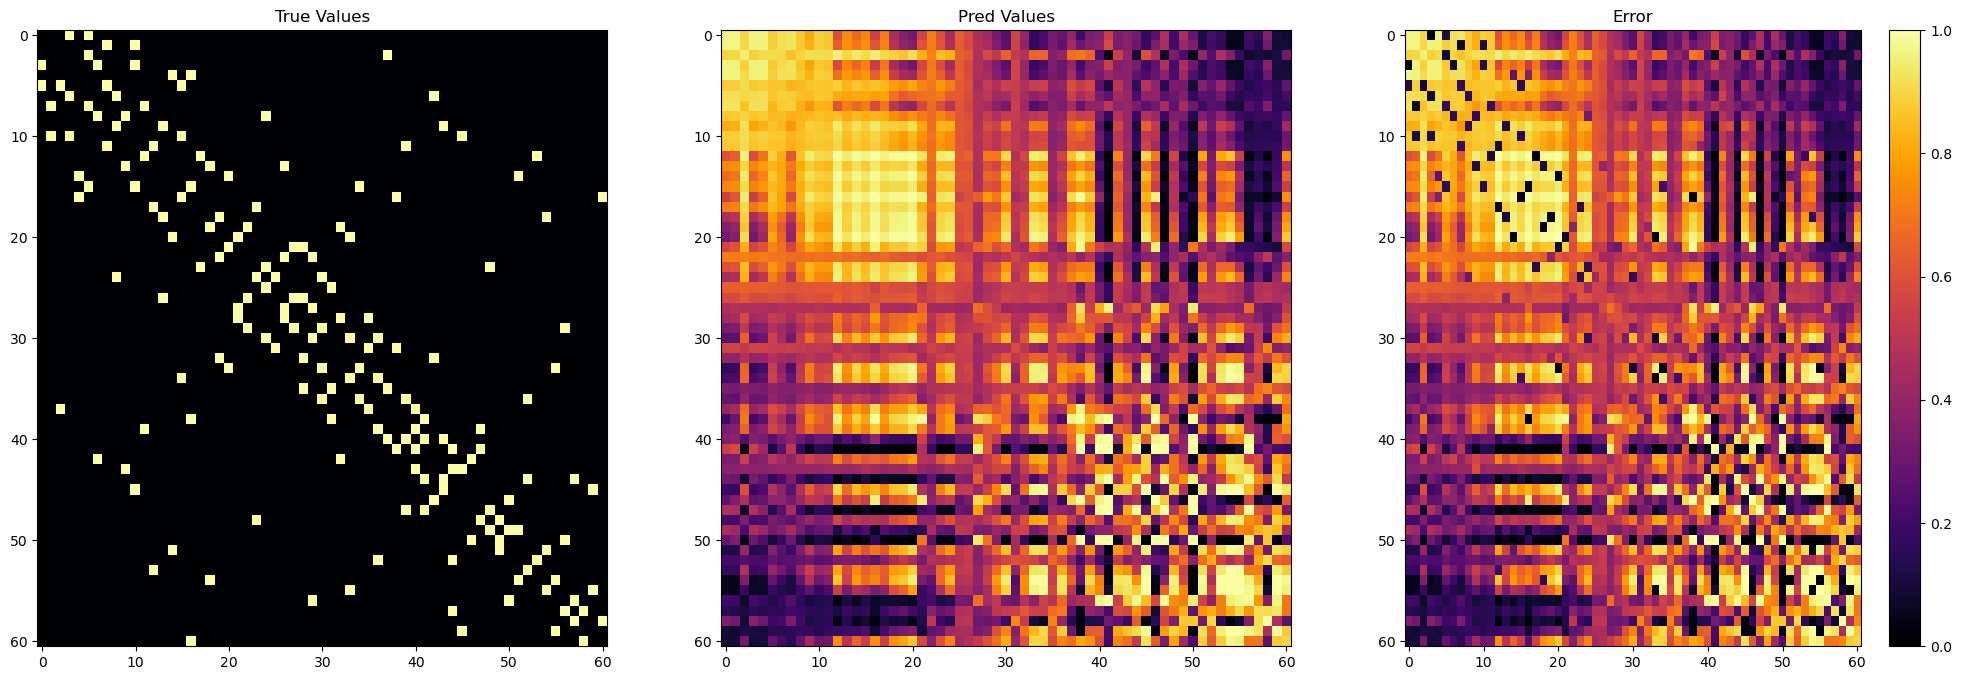

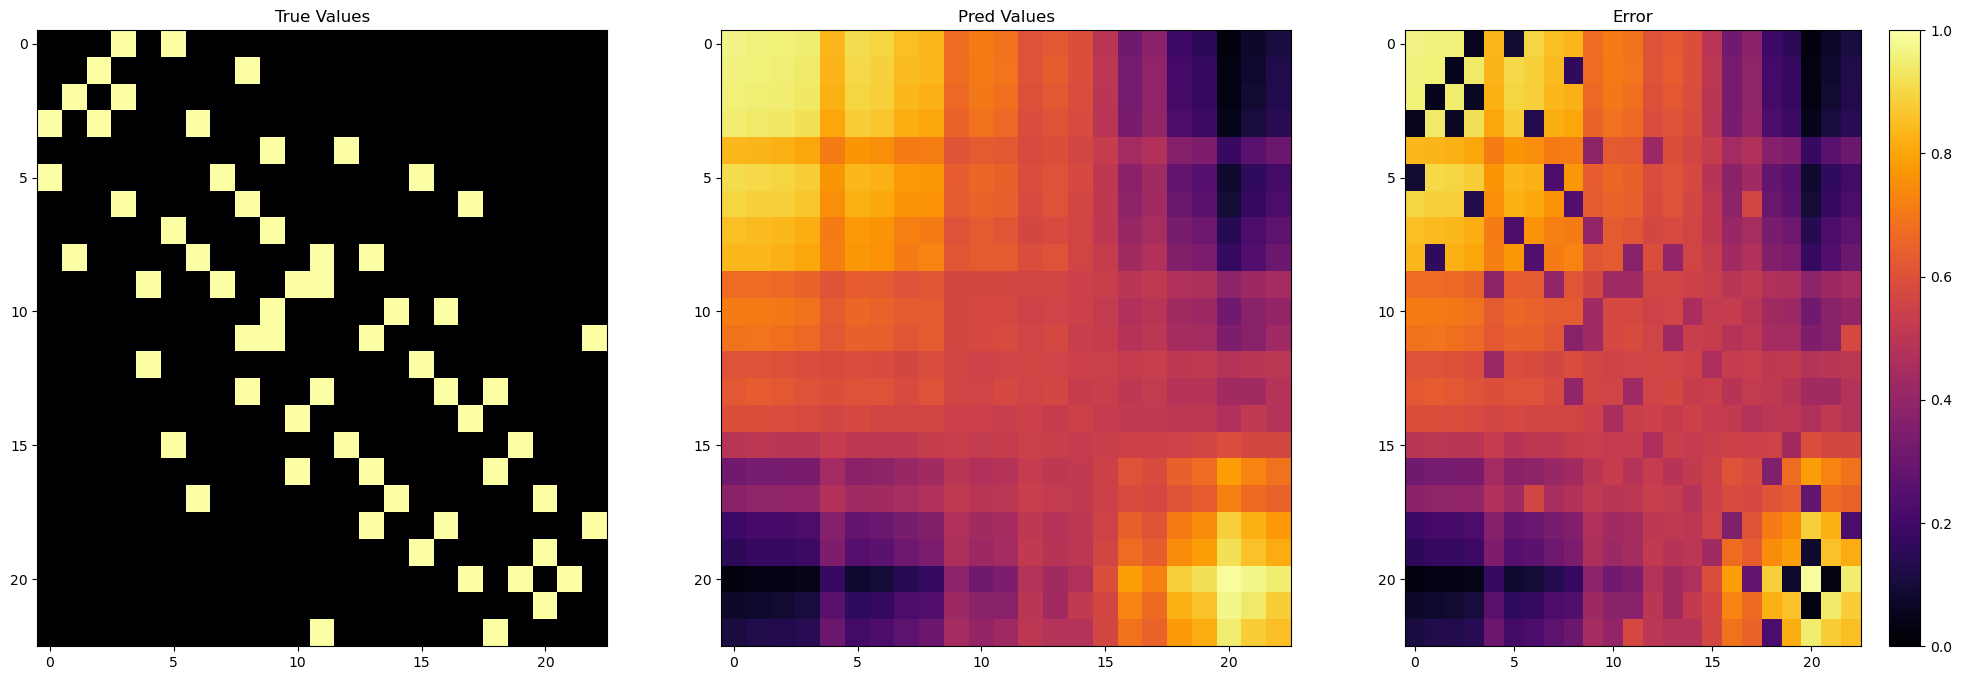

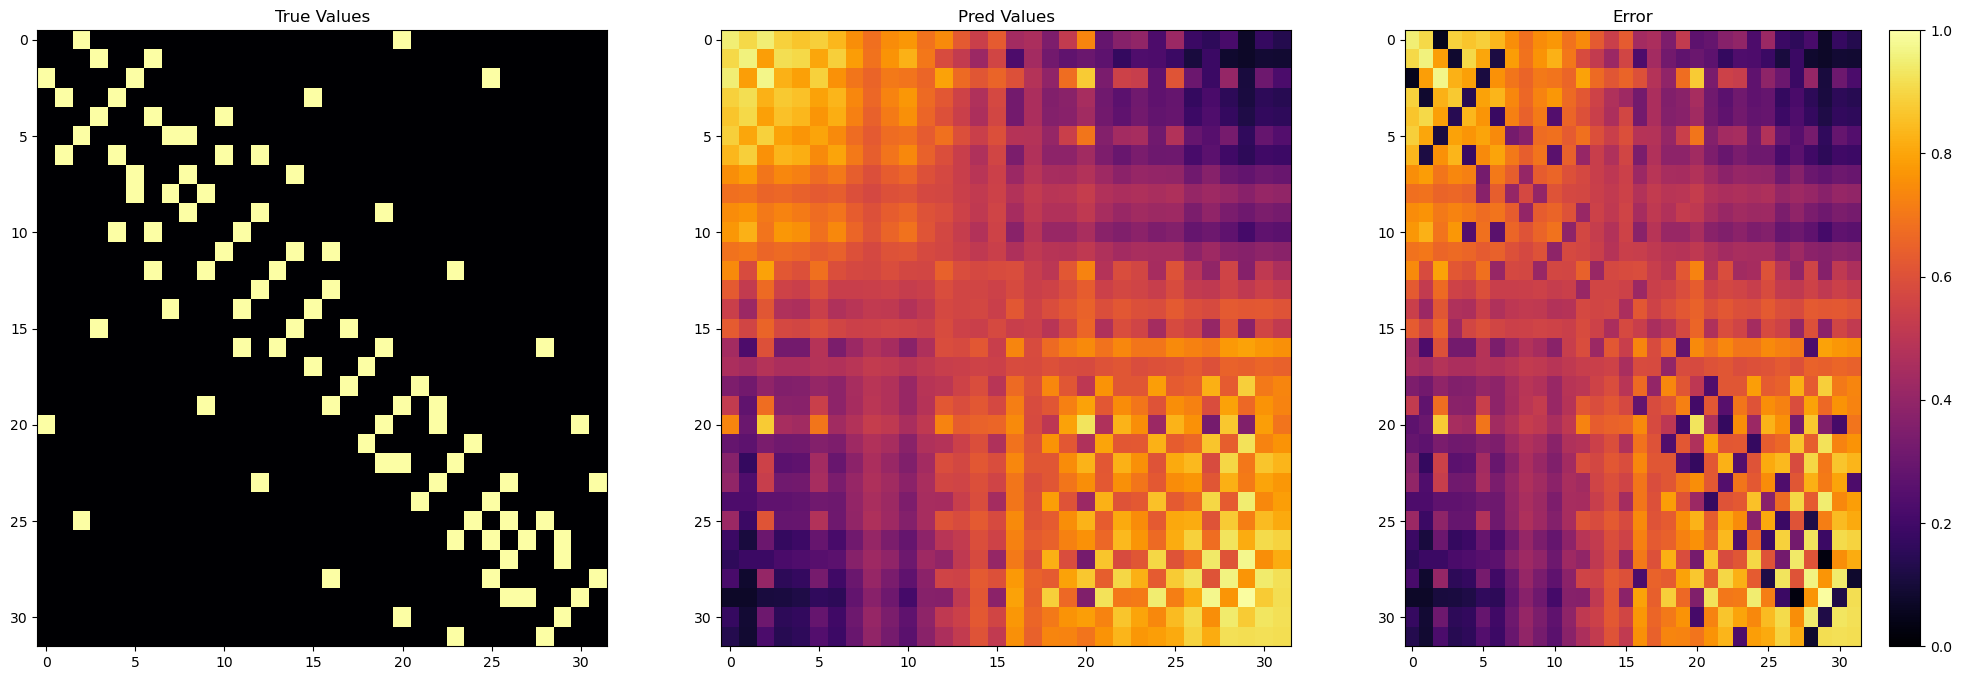

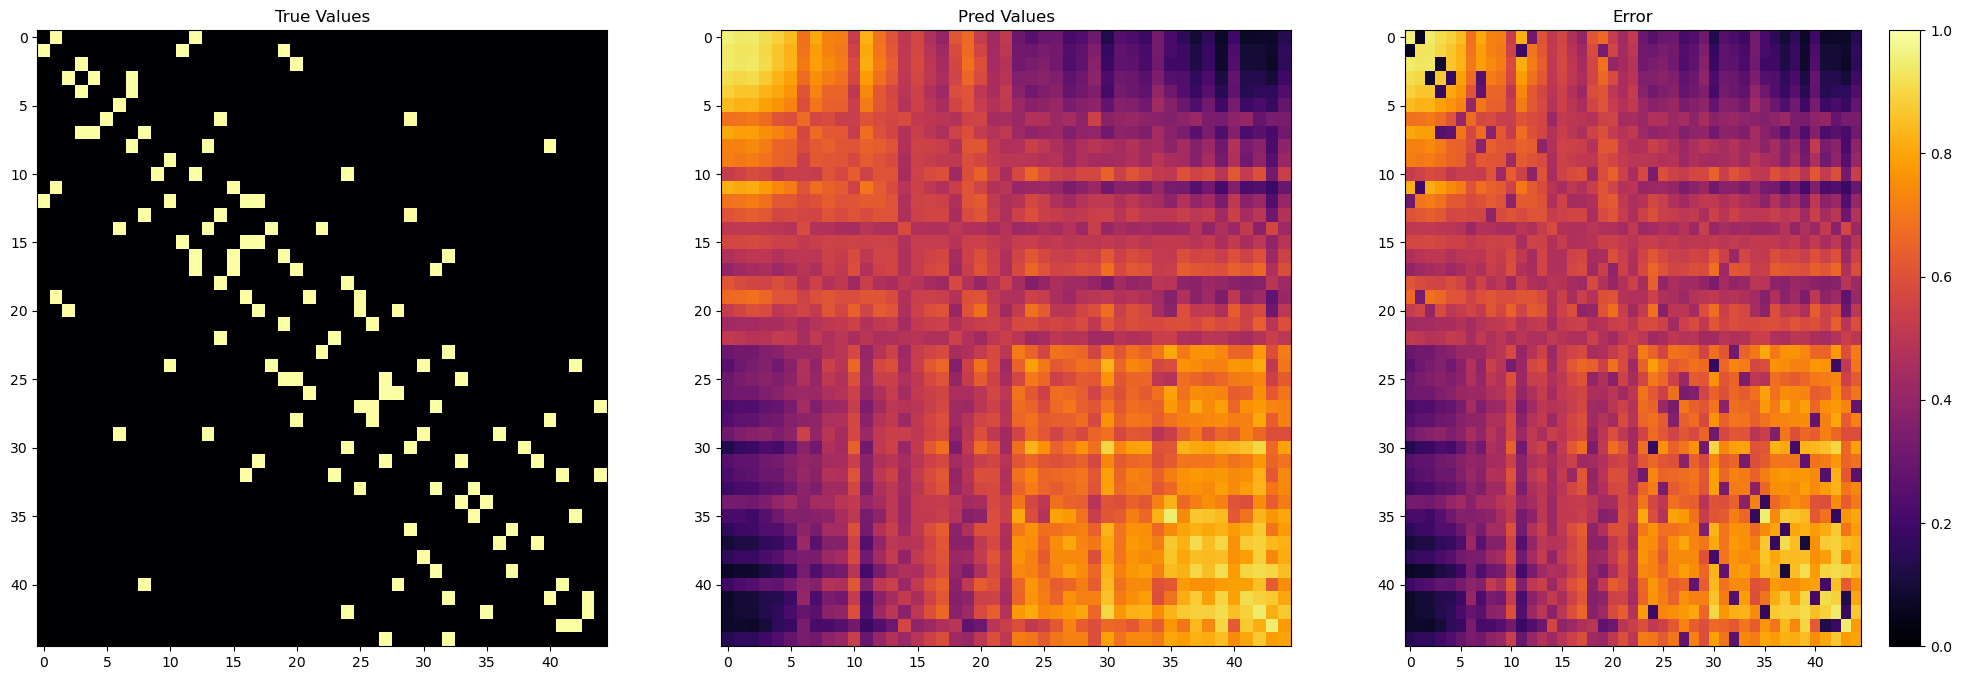

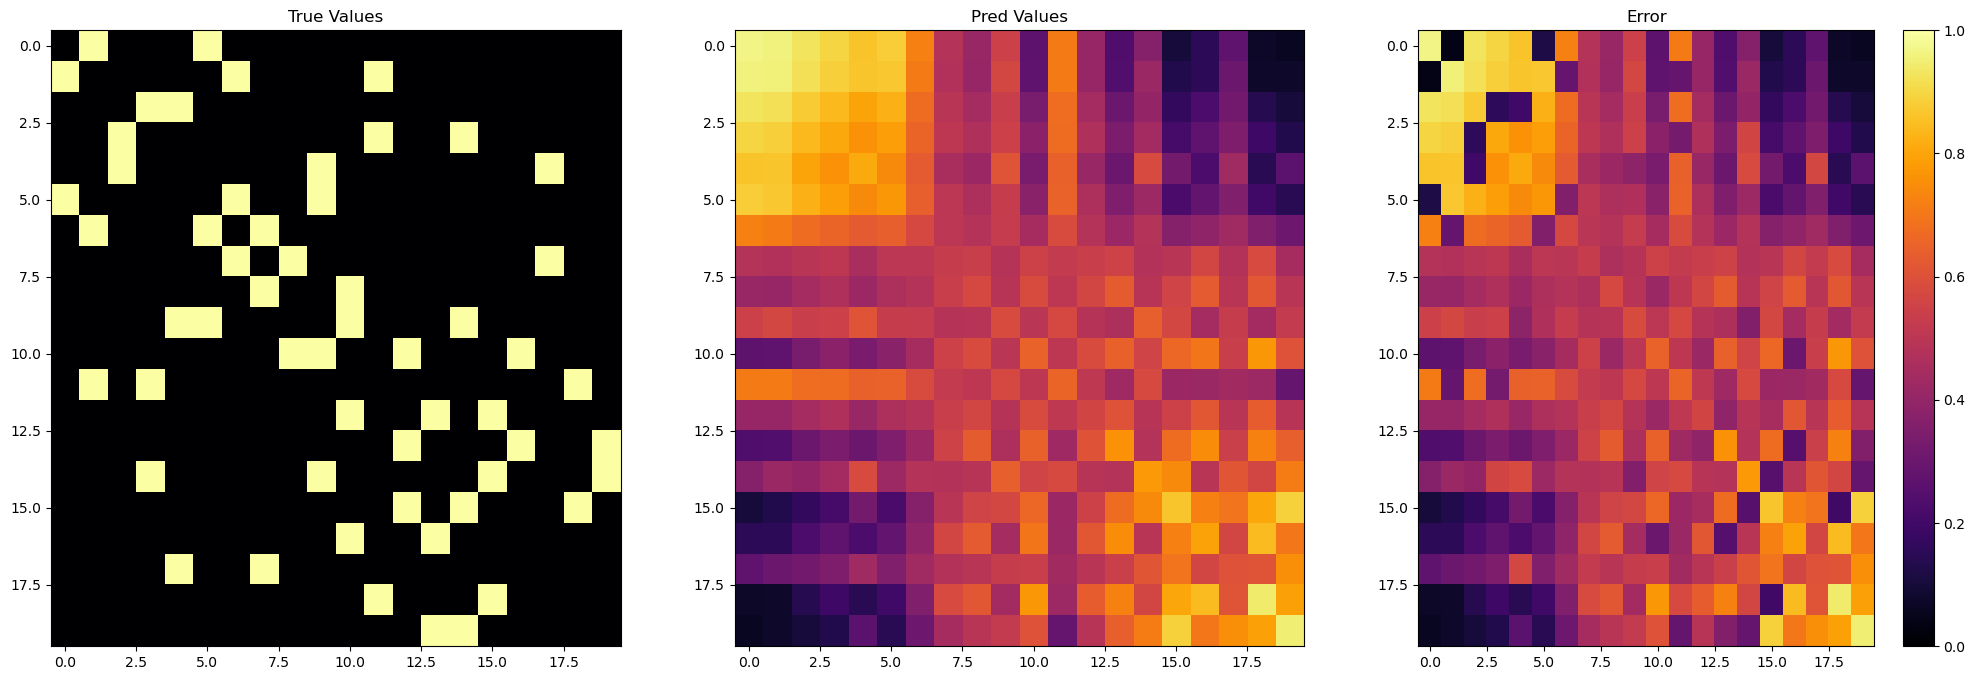

In [30]:
for i in range(20,25):
    plot_adjacency(true_adj[i], predicted_adj[i])

In [8]:
def generate_random_solution(instance, n_machines):
    schedule = []
    jobs = [j['job'] for j in instance]
    current_machine_times = np.zeros(n_machines)
    current_job_times = np.zeros(len(jobs))
    while len(jobs) > 0:
        random_job = np.random.choice(jobs)
        jobdata = next(filter(lambda j: j['job'] == random_job, instance))
        ops = jobdata['ops']
        next_op = ops.pop(0)
        machine_data = np.random.choice(next_op['machines'])
        machine = machine_data['machine']
        machine_idx = int(machine[1:]) - 1
        job_idx = int(random_job[1:]) - 1
        duration = machine_data['dur']
        machine_available_at = current_machine_times[machine_idx]
        job_available_at = current_job_times[job_idx]
        start_time = max((machine_available_at, job_available_at))
        end_time = start_time + duration
        entry = {
            "start_time": start_time,
            "end_time": end_time,
            "resource": int(machine[1:]),
            "job": random_job,
            "op": f"{random_job[1:]}_{next_op['i']}",
            "machine_choices": next_op['machines']
        }
        current_machine_times[machine_idx] = end_time
        current_job_times[job_idx] = end_time
        if len(ops) == 0:
            jobs.remove(random_job)
        schedule.append(entry)
    return schedule

In [3]:
def plot_igraph_dag(g):
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    edge_colors = ['Maroon' if e['edge_type'] == 1 else 'Gray' for e in g.es()]
    ig.plot(g,
            target= ax,
            vertex_size=40,
            vertex_color='grey',
            vertex_label=g.vs['jro'],
            edge_color=edge_colors,
            edge_width=4)
           

In [11]:
instance, machines = parse_instance(instance='./../shifting_agent_gnn/environment/instances/hurink_edata/la01.fjs')
instance = instance[:5] # noch kleiner
for idx, job in enumerate(instance):
    if len(job['ops']) > idx + 1:
        job['ops'] = job['ops'][:idx + 1]

N_SOLUTIONS = 500
random_solutions = [generate_random_solution(fast_deepcopy(instance), machines) for _ in range(N_SOLUTIONS)]

In [12]:
random_solutions[3]

[{'start_time': 0.0,
  'end_time': 83.0,
  'resource': 1,
  'job': 'j5',
  'op': '5_0',
  'machine_choices': [{'machine': 'm1', 'dur': 83}]},
 {'start_time': 83.0,
  'end_time': 104.0,
  'resource': 1,
  'job': 'j2',
  'op': '2_0',
  'machine_choices': [{'machine': 'm1', 'dur': 21}]},
 {'start_time': 83.0,
  'end_time': 117.0,
  'resource': 3,
  'job': 'j5',
  'op': '5_1',
  'machine_choices': [{'machine': 'm4', 'dur': 34},
   {'machine': 'm3', 'dur': 34}]},
 {'start_time': 104.0,
  'end_time': 156.0,
  'resource': 4,
  'job': 'j2',
  'op': '2_1',
  'machine_choices': [{'machine': 'm4', 'dur': 52}]},
 {'start_time': 0.0,
  'end_time': 77.0,
  'resource': 2,
  'job': 'j4',
  'op': '4_0',
  'machine_choices': [{'machine': 'm2', 'dur': 77},
   {'machine': 'm5', 'dur': 77}]},
 {'start_time': 117.0,
  'end_time': 181.0,
  'resource': 3,
  'job': 'j5',
  'op': '5_2',
  'machine_choices': [{'machine': 'm3', 'dur': 64}]},
 {'start_time': 77.0,
  'end_time': 98.0,
  'resource': 2,
  'job': 'j1'

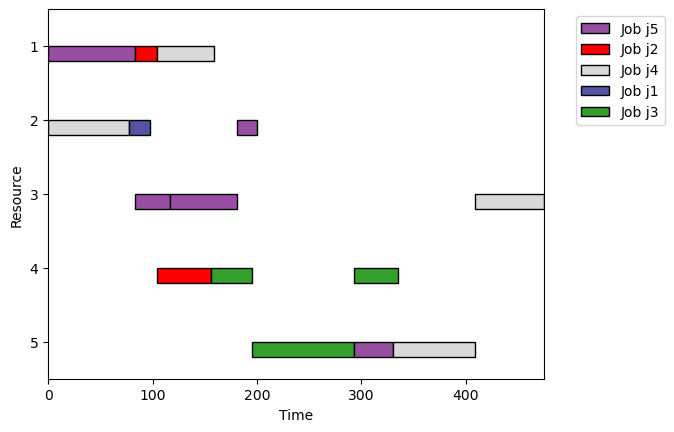

In [13]:
gantt_plotter_matplotlib.plot_gantt(random_solutions[3])

In [16]:
random_sol_graphs = [schedule_data_to_igraph(schedule)[0] for schedule in random_solutions]

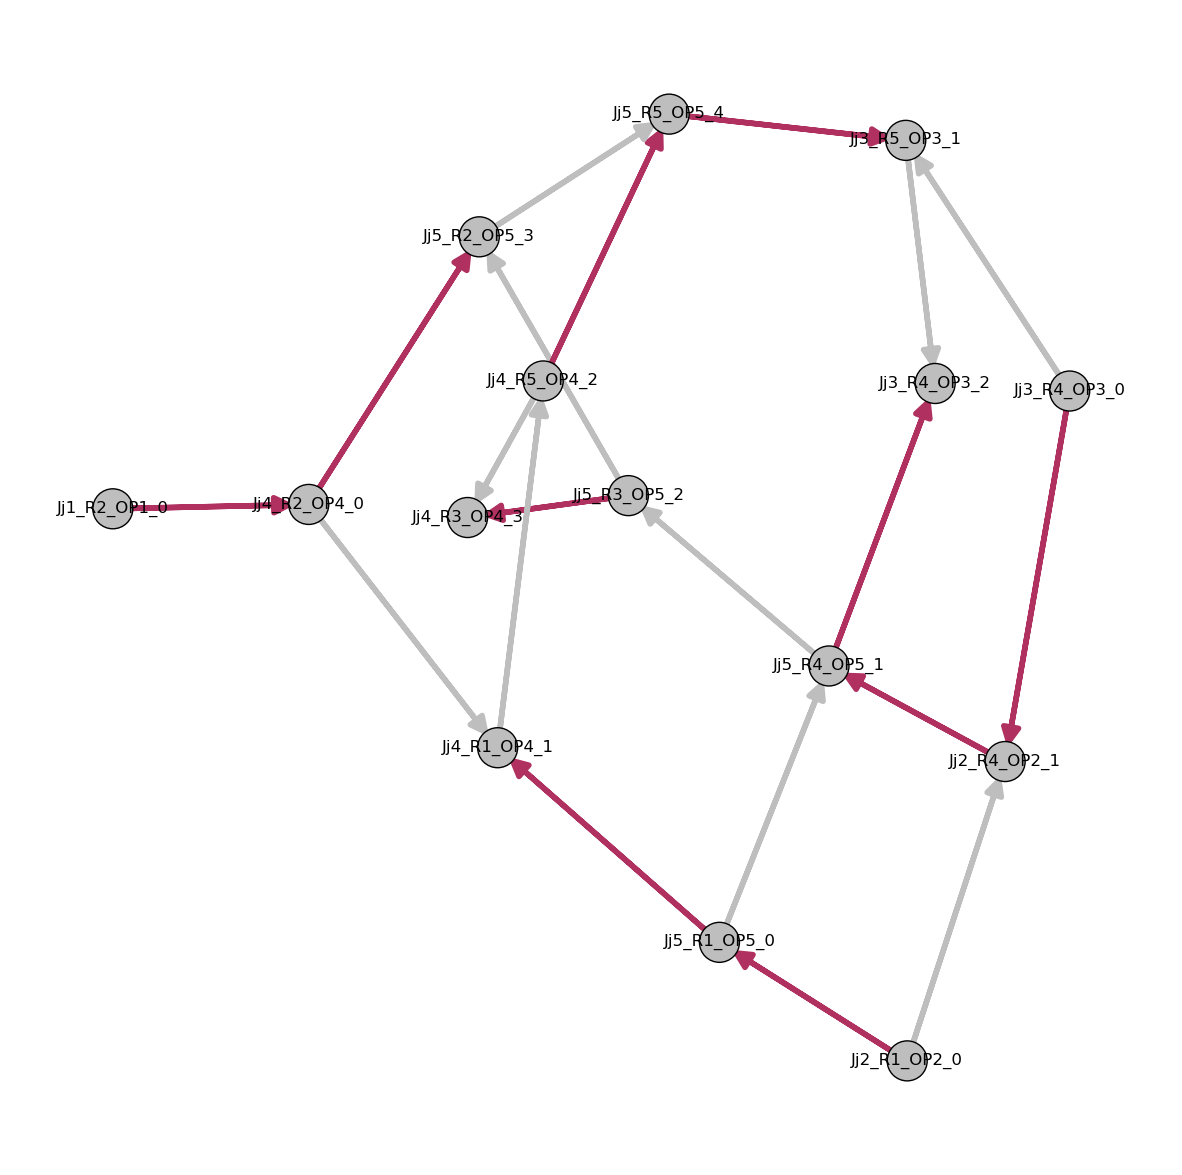

In [9]:
plot_igraph_dag(random_sol_graphs[3])

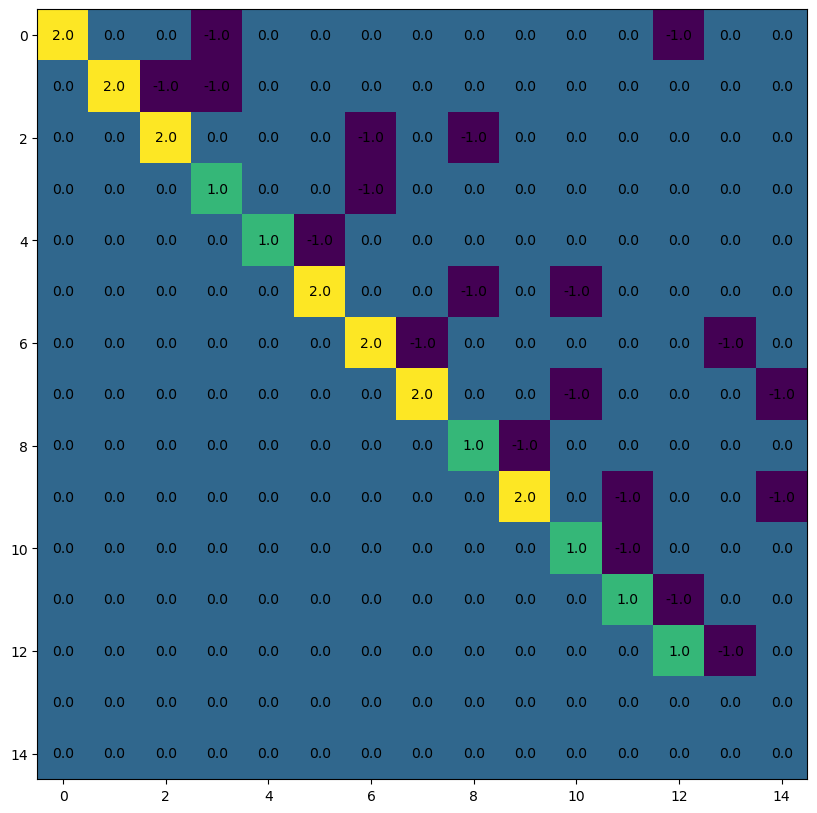

In [10]:
laplacian = np.array(random_sol_graphs[3].laplacian())
fig, ax = plt.subplots(1, 1, figsize=[10, 10])
ax.imshow(laplacian)
for (j,i),label in np.ndenumerate(laplacian):
    ax.text(i,j,label,ha='center',va='center')

In [11]:
def adj_numpy(graph):
    adj_mat = graph.get_adjacency()
    n_rows = adj_mat.shape[0]
    data = []
    for idx in range(n_rows):
        data.append(adj_mat[idx])
    return np.array(data)

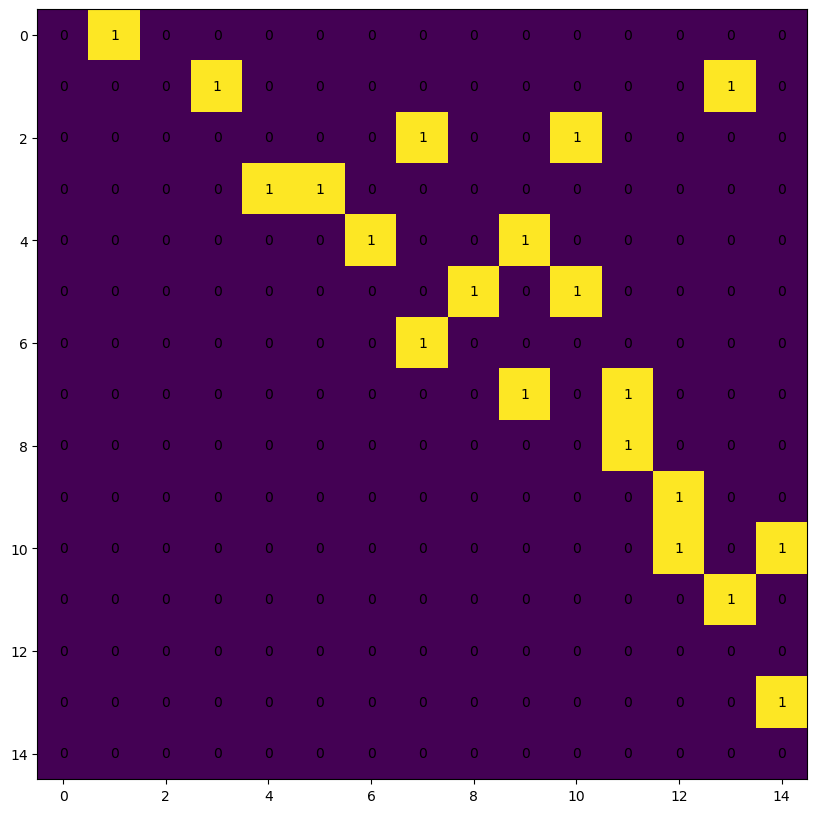

In [12]:
adj = adj_numpy(random_sol_graphs[2])
fig, ax = plt.subplots(1, 1, figsize=[10, 10])
ax.imshow(adj)
for (j,i),label in np.ndenumerate(adj):
    ax.text(i,j,label,ha='center',va='center')

In [13]:
def order_nodes(graph, order):
    """
    Many methods assume equal order of nodes to compare adj. / lapl. matrix.
    :param order list ['job_op']
    """
    permutation = []
    for v in graph.vs():
        search_string = f"{v['job']}_{v['op']}"
        idx = order.index(search_string)
        permutation.append(idx)
    graph.permute_vertices(permutation)
    return graph

In [14]:
order = [f"{v['job']}_{v['op']}" for v in random_sol_graphs[0].vs()]
random_sol_graphs = [order_nodes(graph, order) for graph in random_sol_graphs]

In [15]:
def spectral_distance(mat1, mat2):
    """
    Spectral distances of the adjacency matrix are only sensible for undirected graphs. For directed graphs the adj matrix is
    an upper triangular matrix -> nilpotent -> all eig values are 0.
    """
    eig_vals_1, eig_vecs_1 = np.linalg.eig(mat1)
    eig_vals_2, eig_vecs_2 = np.linalg.eig(mat2)
    distance = np.sqrt(np.sum((eig_vals_1 - eig_vals_2)**2))
    return distance

In [16]:
def get_makespan(g):
    "Makespand fitness metric"
    return max(g.vs()['end_time'])

In [17]:
makespan_values = [get_makespan(g) for g in random_sol_graphs]

In [18]:
# Pairwise distance
pdists = np.zeros([N_SOLUTIONS, N_SOLUTIONS])
for i in range(len(random_sol_graphs)):
    for j in range(len(random_sol_graphs)):
        if i < j:
            l1 = random_sol_graphs[i].laplacian()
            l2 = random_sol_graphs[j].laplacian()
            pdists[i, j] = spectral_distance(l1, l2)

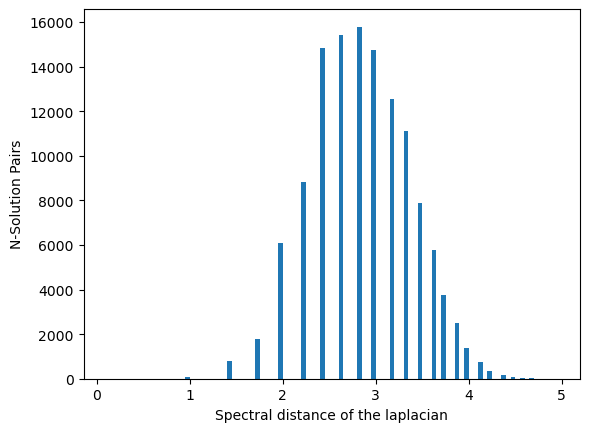

In [19]:
# Plot Spectral laplacian distances
plt.hist(np.triu(pdists).flatten(), bins=np.arange(0.1, 5, 0.05))
plt.xlabel("Spectral distance of the laplacian")
plt.ylabel("N-Solution Pairs")
plt.show()

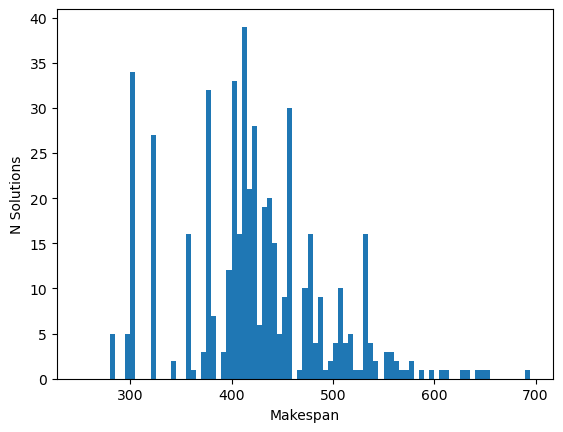

In [20]:
# Plot Spectral laplacian distances
plt.hist(makespan_values, bins=np.arange(250, 700, 5))
plt.xlabel("Makespan")
plt.ylabel("N Solutions")
plt.show()

In [21]:
# Pairwise distance
makespan_dist = np.zeros([N_SOLUTIONS, N_SOLUTIONS])
for i in range(len(random_sol_graphs)):
    for j in range(len(random_sol_graphs)):
        if i < j:
            makespan_dist[i, j] = makespan_values[i] - makespan_values[j]

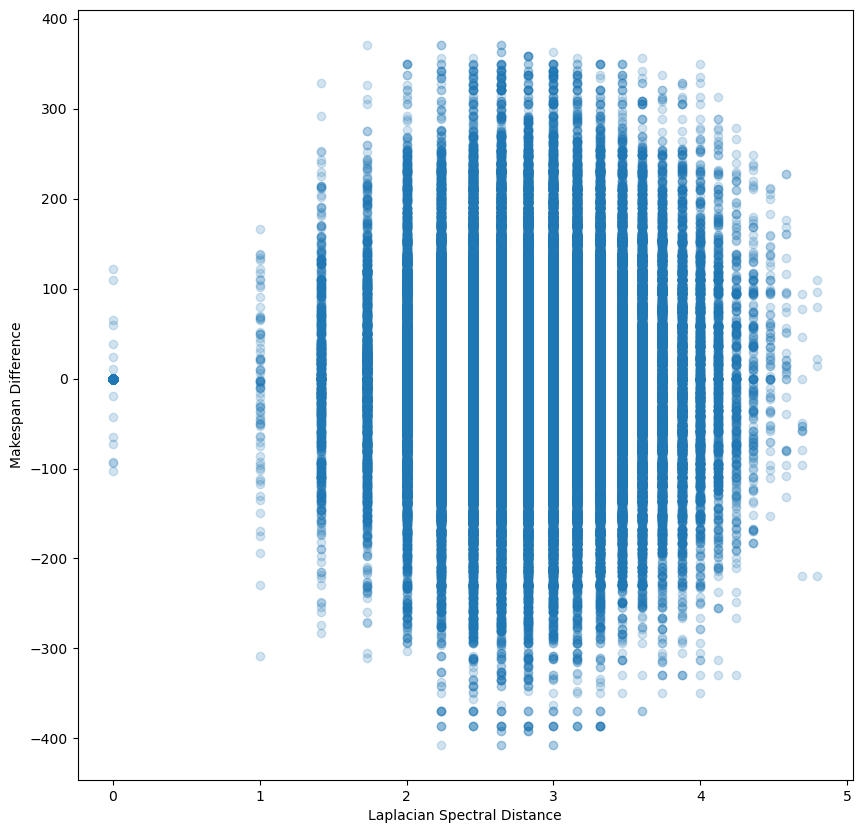

In [22]:
plt.figure(figsize=[10, 10])
plt.scatter(np.triu(pdists).flatten(), np.triu(makespan_dist).flatten(), alpha=0.2)
plt.xlabel('Laplacian Spectral Distance')
plt.ylabel('Makespan Difference')
plt.show()

In [23]:
def edit_distance(a1, a2):
    return np.linalg.norm(a1 - a2, 1)

In [24]:
# Pairwise distance
edit_dists = np.zeros([N_SOLUTIONS, N_SOLUTIONS])
for i in range(len(random_sol_graphs)):
    for j in range(len(random_sol_graphs)):
        if i < j:
            a1 = adj_numpy(random_sol_graphs[i])
            a2 = adj_numpy(random_sol_graphs[j])
            edit_dists[i, j] = edit_distance(a1, a2)

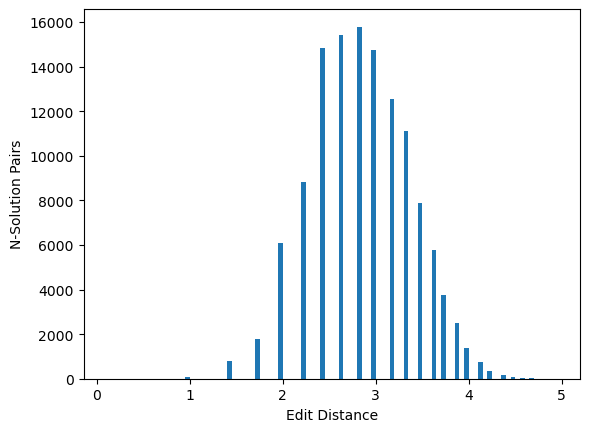

In [25]:
# Plot Spectral laplacian distances
plt.hist(np.triu(pdists).flatten(), bins=np.arange(0.1, 5, 0.05))
plt.xlabel("Edit Distance")
plt.ylabel("N-Solution Pairs")
plt.show()

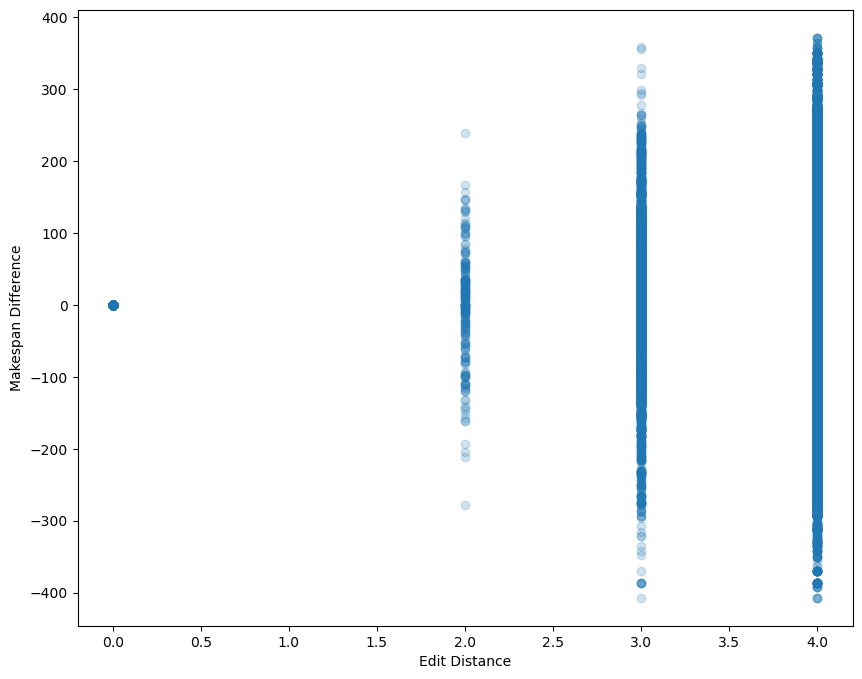

In [26]:
plt.figure(figsize=[10, 8])
plt.scatter(np.triu(edit_dists).flatten(), np.triu(makespan_dist).flatten(), alpha=0.2)
plt.xlabel('Edit Distance')
plt.ylabel('Makespan Difference')
plt.show()